In [345]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# tools
import joblib
from typing import Tuple

# preprocess
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# model
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMRegressor

### 컬럼설명
* Hour - 시간
* Minute - 분
* DHI - 수평면 산란일사량(Diffuse Horizontal Irradiance (W/m2)) : 태양광선이 대기를 통과하는 동안에 공기분자, 구름, 연무(aerosol) 입자 등으로 인하여 산란되어 도달되는 햇볕
* DNI - 직달일사량(Direct Normal Irradiance (W/m2)) : 태양으로부터 지표에 직접 도달하는 햇볕
* WS - 풍속(Wind Speed (m/s))
* RH - 상대습도(Relative Humidity (%))
* T - 기온(Temperature (Degree C))
* Target - 태양광 발전량 (kW)

In [346]:
df = pd.read_csv('../00_data/train/train.csv')
df

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0
...,...,...,...,...,...,...,...,...,...
52555,1094,21,30,0,0,2.4,70.70,-4,0.0
52556,1094,22,0,0,0,2.4,66.79,-4,0.0
52557,1094,22,30,0,0,2.2,66.78,-4,0.0
52558,1094,23,0,0,0,2.1,67.72,-4,0.0


In [347]:
df.describe()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
count,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000
mean,547.000000,11.500000,15.000000,64.344121,234.792371,2.456033,56.793102,9.279928,17.790630
std,316.102148,6.922252,15.000143,103.897125,349.684583,1.426874,22.052875,10.179741,25.759955
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.590000,-19.000000,0.000000
25%,273.000000,5.750000,0.000000,0.000000,0.000000,1.400000,39.697500,1.000000,0.000000
50%,547.000000,11.500000,15.000000,0.000000,0.000000,2.200000,57.600000,9.000000,0.000000
75%,821.000000,17.250000,30.000000,87.000000,469.000000,3.200000,72.770000,17.000000,32.089890
max,1094.000000,23.000000,30.000000,528.000000,1059.000000,12.000000,100.000000,35.000000,99.913939


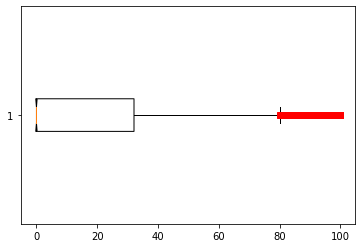

In [348]:
plt.boxplot(df.TARGET, 
            notch=1, # if 'True' then notched box plot
            sym='rs', # symbol: red square
            vert=0 # vertical : if 'False' then horizontal box plot
           )
plt.show()

In [349]:
quan_val = []
for i in range(4):
    quan_val.append(df.TARGET.quantile(0.25*(i+1)))
print(quan_val)

[0.0, 0.0, 32.0898895075, 99.91393869]


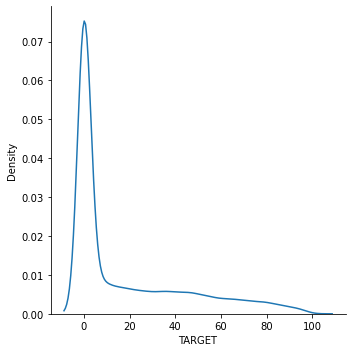

In [350]:
sns.displot(x=df.TARGET, kind="kde")

In [462]:
def add_variable(df): # 파생변수 생성
    # 주차
    df['week'] = df['Day'] // 7

    # 전체 도달 에너지량 
    # (reference: https://www.researchgate.net/post/Why_does_the_solar_data_DNI_DHI_GHI_obtained_from_the_PVGIS_database_not_match_the_euqation)
    df['sum_energy'] = df['DHI'] + df['DNI']

    # 태양고도
    df['theta'] = 0
    condition_list = [
        (df['Hour'] == 6) | (df['Hour'] == 19),
        (df['Hour'] == 7) | (df['Hour'] == 18),
        (df['Hour'] == 8) | (df['Hour'] == 17),
        (df['Hour'] == 9) | (df['Hour'] == 16),
        (df['Hour'] == 10) | (df['Hour'] == 15),
        (df['Hour'] == 11) | (df['Hour'] == 14),
        (df['Hour'] == 12) | (df['Hour'] == 13)
    ]

    choice_list = [0,10,20,30,40,50,60]

    df['theta'] = np.select(condition_list, choice_list)

    # GHI
    df['GHI'] = df['DNI'] * np.cos(df['theta']) + df['DHI']
    
    #Td
    c = 243.12
    b = 17.62
    gamma = (b * (df['T']) / (c + (df['T']))) + np.log(df['RH'] / 100)
    dp = (c * gamma) / (b - gamma)
    df.insert(1,'Td',dp)
    df.insert(1,'T-Td', df['T']-df['Td'])
    
    return pd.DataFrame(df)


def preprocess(path, delay, add_var): # 데이터 전처리
    df = pd.read_csv(path).copy()
    
    if delay == 1:
        df1 = df[:-48] # 2일씩 delay 시킨 데이터
        df1 = df1.drop('TARGET', axis = 1)
        df1['TARGET'] = df['TARGET'].loc[48:].values
        if add_var == False:
            pass
        else:
            df1 = add_variable(df1)
        return pd.DataFrame(df1)

    elif delay == 2:
        df2 = df[:-96] # 2일씩 delay 시킨 데이터
        df2 = df2.drop('TARGET', axis = 1)
        df2['TARGET'] = df['TARGET'].loc[96:].values
        if add_var == False:
            pass
        else:
            df2 = add_variable(df2)
        return pd.DataFrame(df2)
    else:
        df = df.drop('TARGET', axis=1)
        if add_var == False:
            pass
        else:
            df = add_variable(df)
        return pd.DataFrame(df)
        
        
    
    
def data_split3(df, split): # train:valid:test 로 split
    X = df.drop('TARGET', axis=1)
    y = df['TARGET']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, shuffle = False)
    
    if split == 'valid':
        return X_train, X_valid, X_test, y_train, y_valid, y_test
    elif split == 'test':
        return X_train, X_test, y_train, y_test
    else:
        return X, y

In [463]:
df1 = preprocess('../00_data/train/train.csv', delay = 1, add_var = True)
df2 = preprocess('../00_data/train/train.csv', delay = 2, add_var = True)

In [464]:
#X_train1, X_valid1, X_test1, y_train1, y_valid1, y_test1 = data_split3(df1, 'valid')
#X_train2, X_valid2, X_test2, y_train2, y_valid2, y_test2 = data_split3(df2, 'valid')

In [465]:
X_train1, X_test1, y_train1, y_test1 = data_split3(df1, 'test')
X_train2, X_test2, y_train2, y_test2 = data_split3(df2, 'test')

In [466]:
params = {
    'objective': 'quantile',
    'metric': 'quantile',
    'max_depth': 4,
    'num_leaves': 15,
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'boosting_type': 'gbdt'
}

In [359]:
quantile = np.arange(0.1, 1, 0.1)
global quantile
y_preds = []

def model_training(q, X_train, y_train, X_test):
    #print('prediction of quantile', q)
    lgb = LGBMRegressor(alpha=q, **params)
    model = lgb.fit(X_train, y_train)
    pred = pd.Series(model.predict(X_test).round(2))
    
    return pred, model

In [360]:
def predict_result(X_train, y_train, X_test):
    model_list = []
    predict = pd.DataFrame()

    for q in quantile:
        q = round(q, 2)
        pred, model = model_training(q, X_train, y_train, X_test)
        model_list.append(model)
        predict = pd.concat([predict, pred], axis=1)

    predict.columns=quantile
    
    return model_list, predict

In [442]:
def compute_quantile_loss(y_true, y_pred, quantile):
    residual = y_true - y_pred
    loss = np.mean(np.maximum(quantile * residual, (quantile - 1) * residual))
    print('quantile {} - loss : {}'.format(quantile, loss))
    return loss

In [448]:
def final_loss(y_test, result):
    for j,k in enumerate(quantile):
        loss = 0
        loss += compute_quantile_loss(y_test.values, result.iloc[:, j], quantile = k)
    print('=====================================')

In [449]:
def final_result(X_train, y_train, X_test):
    print('learning...')
    models, result = predict_result(X_train, y_train, X_test)
    print('done...')
    
    result[result < 0]=0
    hour = X_test.Hour.reset_index(drop=True).copy()
    result = pd.concat([result, hour], axis=1)

    for i in range(len(X_test)):
        if (result['Hour'].iloc[i] < 6) | (result['Hour'].iloc[i] > 20):
            result.iloc[i, :] == 0

    result = result.drop('Hour', axis=1)
    
    return models, result

In [450]:
models1, result1 =  final_result(X_train1, y_train1, X_test1)

learning...
done...


In [451]:
final_loss(y_test1, result1)

quantile 0.1 - loss : 1.4955171737396848
quantile 0.2 - loss : 2.7259408285293585
quantile 0.30000000000000004 - loss : 3.461549801826979
quantile 0.4 - loss : 4.336756038741458
quantile 0.5 - loss : 4.408989881416778
quantile 0.6 - loss : 4.385096384690327
quantile 0.7000000000000001 - loss : 4.308208162966486
quantile 0.8 - loss : 4.588373096779802
quantile 0.9 - loss : 3.1146716788849647


In [453]:
models2, result2 =  final_result(X_train2, y_train2, X_test2)
final_loss(y_test2, result2)

learning...
done...
quantile 0.1 - loss : 1.5379518661290794
quantile 0.2 - loss : 2.573764909396072
quantile 0.30000000000000004 - loss : 3.4356298640990666
quantile 0.4 - loss : 3.9068959185686625
quantile 0.5 - loss : 3.7971639283676324
quantile 0.6 - loss : 4.299860177088278
quantile 0.7000000000000001 - loss : 4.001399761399436
quantile 0.8 - loss : 3.61138591626118
quantile 0.9 - loss : 2.349287605015262


In [467]:
# Prediction for submit

i=0
path = '../00_data/test/' + str(i) + '.csv'
df = preprocess(path, 0, add_var = True)
df

,Day,T-Td,Td,Hour,Minute,DHI,DNI,WS,RH,T,week,sum_energy,theta,GHI
0,0,13.876055,-13.876055,0,0,0,0,2.7,34.42,0.0,0,0,0,0.0
1,0,13.976610,-13.876610,0,30,0,0,2.7,34.17,0.1,0,0,0,0.0
2,0,13.966234,-13.766234,1,0,0,0,2.7,34.23,0.2,0,0,0,0.0
3,0,14.063821,-13.763821,1,30,0,0,2.7,33.99,0.3,0,0,0,0.0
4,0,14.082278,-13.682278,2,0,0,0,2.8,33.97,0.4,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,6,7.232220,-15.232220,21,30,0,0,3.6,56.09,-8.0,0,0,0,0.0
332,6,7.781863,-15.981863,22,0,0,0,3.4,53.54,-8.2,0,0,0,0.0
333,6,7.696912,-15.996912,22,30,0,0,3.4,53.89,-8.3,0,0,0,0.0
334,6,8.128435,-16.528435,23,0,0,0,3.4,51.96,-8.4,0,0,0,0.0


In [474]:
pred_list = pd.DataFrame([])
for i in range(len(quantile)):
    regressor = models1[i]
    pred = pd.Series(model.predict(df).round(2))
    pred_list = pd.concat([pred_list, pred], axis=1)

In [ ]:
result[result < 0]=0
    hour = X_test.Hour.reset_index(drop=True).copy()
    result = pd.concat([result, hour], axis=1)

    for i in range(len(X_test)):
        if (result['Hour'].iloc[i] < 6) | (result['Hour'].iloc[i] > 20):
            result.iloc[i, :] == 0

    result = result.drop('Hour', axis=1)

In [ ]:
global quantile

final_result = pd.DataFrame([])

for i in range(0,81):
    path = '../00_data/test/' + str(i) + '.csv'
    df2 = preprocess(path, add_var = True)
    X, y = data_split3(df2, train = False)
    X1 = X.copy()
    X1['Minute'] = X1['Minute'].astype('str')
    X1['Minute'] = X1['Minute'].replace('0','00')
    dtest = xgb.DMatrix(data=X, label=y)
    
    result = pd.DataFrame([])
    result['y_true'] = y.values
    result['id'] = 0
    result['day'] = 0
    result['hour'] = 0
    
    for j,k in enumerate([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
        quantile = k
        loss = 0
        file_name = 'model_{}.pkl'.format(k) 
        model = joblib.load(file_name) 
        
        for h in range(len(X)):
            result['id'].loc[h] = '{}.csv_Day{}_{}h{}m'.format(i, X1['Day'].loc[h]+4,X1['Hour'].loc[h], X1['Minute'].loc[h])
            result['day'].loc[h] = X['Day'].loc[h]+4
            result['hour'].loc[h] = X['Hour'].loc[h]
    
        result['q_{}'.format(k)] = model.predict(dtest) * 1.3
        
        for h in range(len(X)):
            if (result['hour'].iloc[h] < 6) | (result['hour'].iloc[h] > 20):
                result['q_{}'.format(k)].iloc[h] = 0
            if result['q_{}'.format(k)].iloc[h] < 0:
                result['q_{}'.format(k)].iloc[h] = 0
                
        loss += compute_quantile_loss(result['y_true'], result.iloc[:,j+4], quantile = k)
        #print(result.columns)
    print('=================================================')
    final_result = pd.concat([final_result, result])

quantile별 model 학습

In [253]:
quantile = np.arange(0.1, 1, 0.1)
model_list = {}
for i in range(len(quantile)):
    model_list[i] = lgb.train(params, train_ds, 600, test_ds, verbose_eval=20)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2324
[LightGBM] [Info] Number of data points in the train set: 33576, number of used features: 14
[LightGBM] [Info] Start training from score 18.201061
[20]	valid_0's l2: 512.324
[40]	valid_0's l2: 405.399
[60]	valid_0's l2: 331.41
[80]	valid_0's l2: 277.715
[100]	valid_0's l2: 241.972
[120]	valid_0's l2: 218.474
[140]	valid_0's l2: 201.875
[160]	valid_0's l2: 189.063
[180]	valid_0's l2: 181.554
[200]	valid_0's l2: 175.346
[220]	valid_0's l2: 171.117
[240]	valid_0's l2: 167.43
[260]	valid_0's l2: 164.684
[280]	valid_0's l2: 163.263
[300]	valid_0's l2: 162.039
[320]	valid_0's l2: 161.27
[340]	valid_0's l2: 161.001
[360]	valid_0's l2: 160.837
[380]	valid_0's l2: 160.717
[400]	valid_0's l2: 160.456
[420]	valid_0's l2: 160.299
[440]	valid_0's l2: 161.393
[460]	valid_0's l2: 161.25
[480]	valid_0's l2

[120]	valid_0's l2: 218.474
[140]	valid_0's l2: 201.875
[160]	valid_0's l2: 189.063
[180]	valid_0's l2: 181.554
[200]	valid_0's l2: 175.346
[220]	valid_0's l2: 171.117
[240]	valid_0's l2: 167.43
[260]	valid_0's l2: 164.684
[280]	valid_0's l2: 163.263
[300]	valid_0's l2: 162.039
[320]	valid_0's l2: 161.27
[340]	valid_0's l2: 161.001
[360]	valid_0's l2: 160.837
[380]	valid_0's l2: 160.717
[400]	valid_0's l2: 160.456
[420]	valid_0's l2: 160.299
[440]	valid_0's l2: 161.393
[460]	valid_0's l2: 161.25
[480]	valid_0's l2: 161.533
[500]	valid_0's l2: 161.898
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[520]	valid_0's l2: 161.88
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[540]	valid_0's l2: 162.262
[LightGBM] [W

[380]	valid_0's l2: 160.717
[400]	valid_0's l2: 160.456
[420]	valid_0's l2: 160.299
[440]	valid_0's l2: 161.393
[460]	valid_0's l2: 161.25
[480]	valid_0's l2: 161.533
[500]	valid_0's l2: 161.898
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[520]	valid_0's l2: 161.88
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[540]	valid_0's l2: 162.262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[560]	valid_0's l2: 162.524
[LightGBM] [Warning] No further splits with pos